In [20]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sksurv.preprocessing import OneHotEncoder
# from pysurvival.models.simulations import SimulationModel
from pysurvival.models.semi_parametric import NonLinearCoxPHModel
from pysurvival.utils.metrics import brier_score
from pysurvival.utils.display import integrated_brier_score

In [21]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

In [22]:
train = pd.read_csv("datasets/train.csv",  index_col='ID')

## Cleaning Data

In [23]:
numeric_clmn = ['LAB1300',  'LAB1301',  'LAB1307',  'LAB1309',
                 'LAB1311', 'LAB1313',  'LAB1314',  'LAB1316',
                 'LAB2404', 'LAB2405',  'LAB2406',  'LAB2407',
                 'LAB2419',  'LAB2422',  'LAB2467',  'LAB2469',
                 'LAB2476',  'LAB2498',  'LAB2544',  'LAB2679',
                 'LAB4176',  'MC1R', 'age',
                 'LABGF_filtrat_glomerular',
                 'cutaneous_biopsy_breslow',
                 'count_inv_prec_tumour',
                 'count_situ_prec_tumour',
                 'cutaneous_biopsy_mitotic_index',
                 'neutrofils_per_limfocits',
                 'limfocits_per_monocits',
                 'slnb_ldn_location_total',
                 'total_count_slnb_ldn',
                 'total_positives_slnb_ldn']

label_clmn = [ 'specific_death', 'months_survival']

datetime = ['T0_date']

cat_clmn = ['patient_gender',
                'patient_eye_color',
                'patient_hair_color',
#                 'patient_phototype',
                'primary_tumour_location_coded',
                'cutaneous_biopsy_ulceration',
                'cutaneous_biopsy_satellitosis',
                'cutaneous_biopsy_vascular_invasion',
                'cutaneous_biopsy_neurotropism',
                'cutaneous_biopsy_lymphatic_invasion',
                'cutaneous_biopsy_predominant_cell_type',
                'cutaneous_biopsy_associated_nevus',
                'cutaneous_biopsy_histological_subtype',
                'cutaneous_biopsy_regression',
                'scenario',
                'visceral_metastasis_location']

len(numeric_clmn) + len(label_clmn) + len(datetime) + len(cat_clmn)

51

In [24]:
total_null = train.isna().sum().sort_values(ascending=False)
percent = 100*(train.isna().sum()/train.isna().count()).sort_values(ascending=False)
missing_data = pd.concat([total_null, percent], axis=1, keys=['Total', 'Percent'])

In [25]:
train.drop('ID12070', inplace=True) #The patient is an outlier
# encoder = OneHotEncoder()

In [26]:
def replace_outlier(df, column, threshold, direction='max'):
    fmean = df[column].mean()
    if direction == 'max':
        df[column] = df[column].apply(lambda x: fmean if x > threshold else x)
        for item in df[df[column] > threshold].index:
            df.loc[item, (column+'_nan')] = True
    elif direction == 'min':
        df[column] = df[column].apply(lambda x: fmean if x < threshold else x)
        for item in df[df[column] < threshold].index:
            df.loc[item, (column+'_nan')] = True

#df.drop('LAB1316', axis=1, inplace=True) #Highly correlated with LAB1309
#df.drop('limfocits_per_monocits', axis=1, inplace=True) #Highly correlated with LAB1309
#df.drop('slnb_ldn_location_total', axis=1, inplace=True) #83% are NaN
#df.drop('visceral_metastasis_location', axis=1, inplace=True) #98% are NaN


def clean_data(df):
    df[numeric_clmn]=df[numeric_clmn].fillna(df[numeric_clmn].mean())
    df[cat_clmn]=df[cat_clmn].fillna("default")

    
    replace_outlier(df, 'LAB1311', 2)
    replace_outlier(df, 'LAB2406', 1000)
    replace_outlier(df, 'LAB2407', 6)
    replace_outlier(df, 'LAB2476', 1000)
    replace_outlier(df, 'LAB2544', 15)
    replace_outlier(df, 'LAB4176', 60)
    replace_outlier(df, 'age', 10, 'min')
    
    df['T0_date'] = pd.to_datetime(df['T0_date'],format='%Y-%m-%d')
    
    #df = pd.get_dummies(df, `+`+=cat_clmn)
    return df

dataset = clean_data(train)

In [27]:
# df = pd.get_dummies(df, columns=['cutaneous_biopsy_associated_nevus', 'month', 'year', 'scenario', 'primary_tumour_location_coded', 'patient_hair_color', 'patient_eye_color', 'cutaneous_biopsy_vascular_invasion', 'cutaneous_biopsy_ulceration', 'cutaneous_biopsy_satellitosis', 'cutaneous_biopsy_regression', 'cutaneous_biopsy_predominant_cell_type', 'cutaneous_biopsy_neurotropism', 'cutaneous_biopsy_lymphatic_invasion', 'cutaneous_biopsy_histological_subtype', 'patient_phototype','patient_gender'])

# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# df2 = df.select_dtypes(include=['float64', 'int64'])
# scaler.fit(df2)
# df_norm = pd.DataFrame(scaler.transform(df2), columns=df2.columns, index=df2.index)
# df[df2.columns] = df_norm[df2.columns]

# dataset[cat_clmn] = encoder.fit_transform(dataset[cat_clmn])

# dataset[cat_clmn]

label_encoders = {}
from sklearn.preprocessing import LabelEncoder
for cat_col in cat_clmn:
    label_encoders[cat_col] = LabelEncoder()
    dataset[cat_col] = label_encoders[cat_col].fit_transform(dataset[cat_col])

In [28]:
# dataset[cat_clmn]

In [29]:
clmn_2drop = ['LAB1316','limfocits_per_monocits','slnb_ldn_location_total','visceral_metastasis_location']

clmn_list = train.columns.values.tolist()
clmn_exclude = (label_clmn + datetime + clmn_2drop)

for clmn_ex in clmn_exclude:
    for clmn_tr in train.columns.values.tolist():
        if clmn_ex in clmn_tr: # go to the next column in DataFrame
            clmn_list.remove(clmn_tr)

clmn_list

['patient_gender',
 'patient_eye_color',
 'patient_hair_color',
 'patient_phototype',
 'primary_tumour_location_coded',
 'cutaneous_biopsy_breslow',
 'cutaneous_biopsy_ulceration',
 'cutaneous_biopsy_satellitosis',
 'cutaneous_biopsy_vascular_invasion',
 'cutaneous_biopsy_neurotropism',
 'cutaneous_biopsy_lymphatic_invasion',
 'cutaneous_biopsy_predominant_cell_type',
 'cutaneous_biopsy_associated_nevus',
 'cutaneous_biopsy_mitotic_index',
 'cutaneous_biopsy_histological_subtype',
 'cutaneous_biopsy_regression',
 'count_inv_prec_tumour',
 'count_situ_prec_tumour',
 'total_count_slnb_ldn',
 'total_positives_slnb_ldn',
 'scenario',
 'MC1R',
 'age',
 'LAB1300',
 'LAB1301',
 'LAB1307',
 'LAB1309',
 'LAB1311',
 'LAB1313',
 'LAB1314',
 'LAB2404',
 'LAB2405',
 'LAB2406',
 'LAB2407',
 'LAB2419',
 'LAB2422',
 'LAB2467',
 'LAB2469',
 'LAB2476',
 'LAB2498',
 'LAB2544',
 'LAB2679',
 'LAB4176',
 'neutrofils_per_limfocits',
 'LABGF_filtrat_glomerular']

In [11]:
dataset.replace(np.nan, dataset.mean(), inplace=True)

In [12]:
features = np.setdiff1d(dataset.columns, ['months_survival', 'specific_death'] ).tolist()

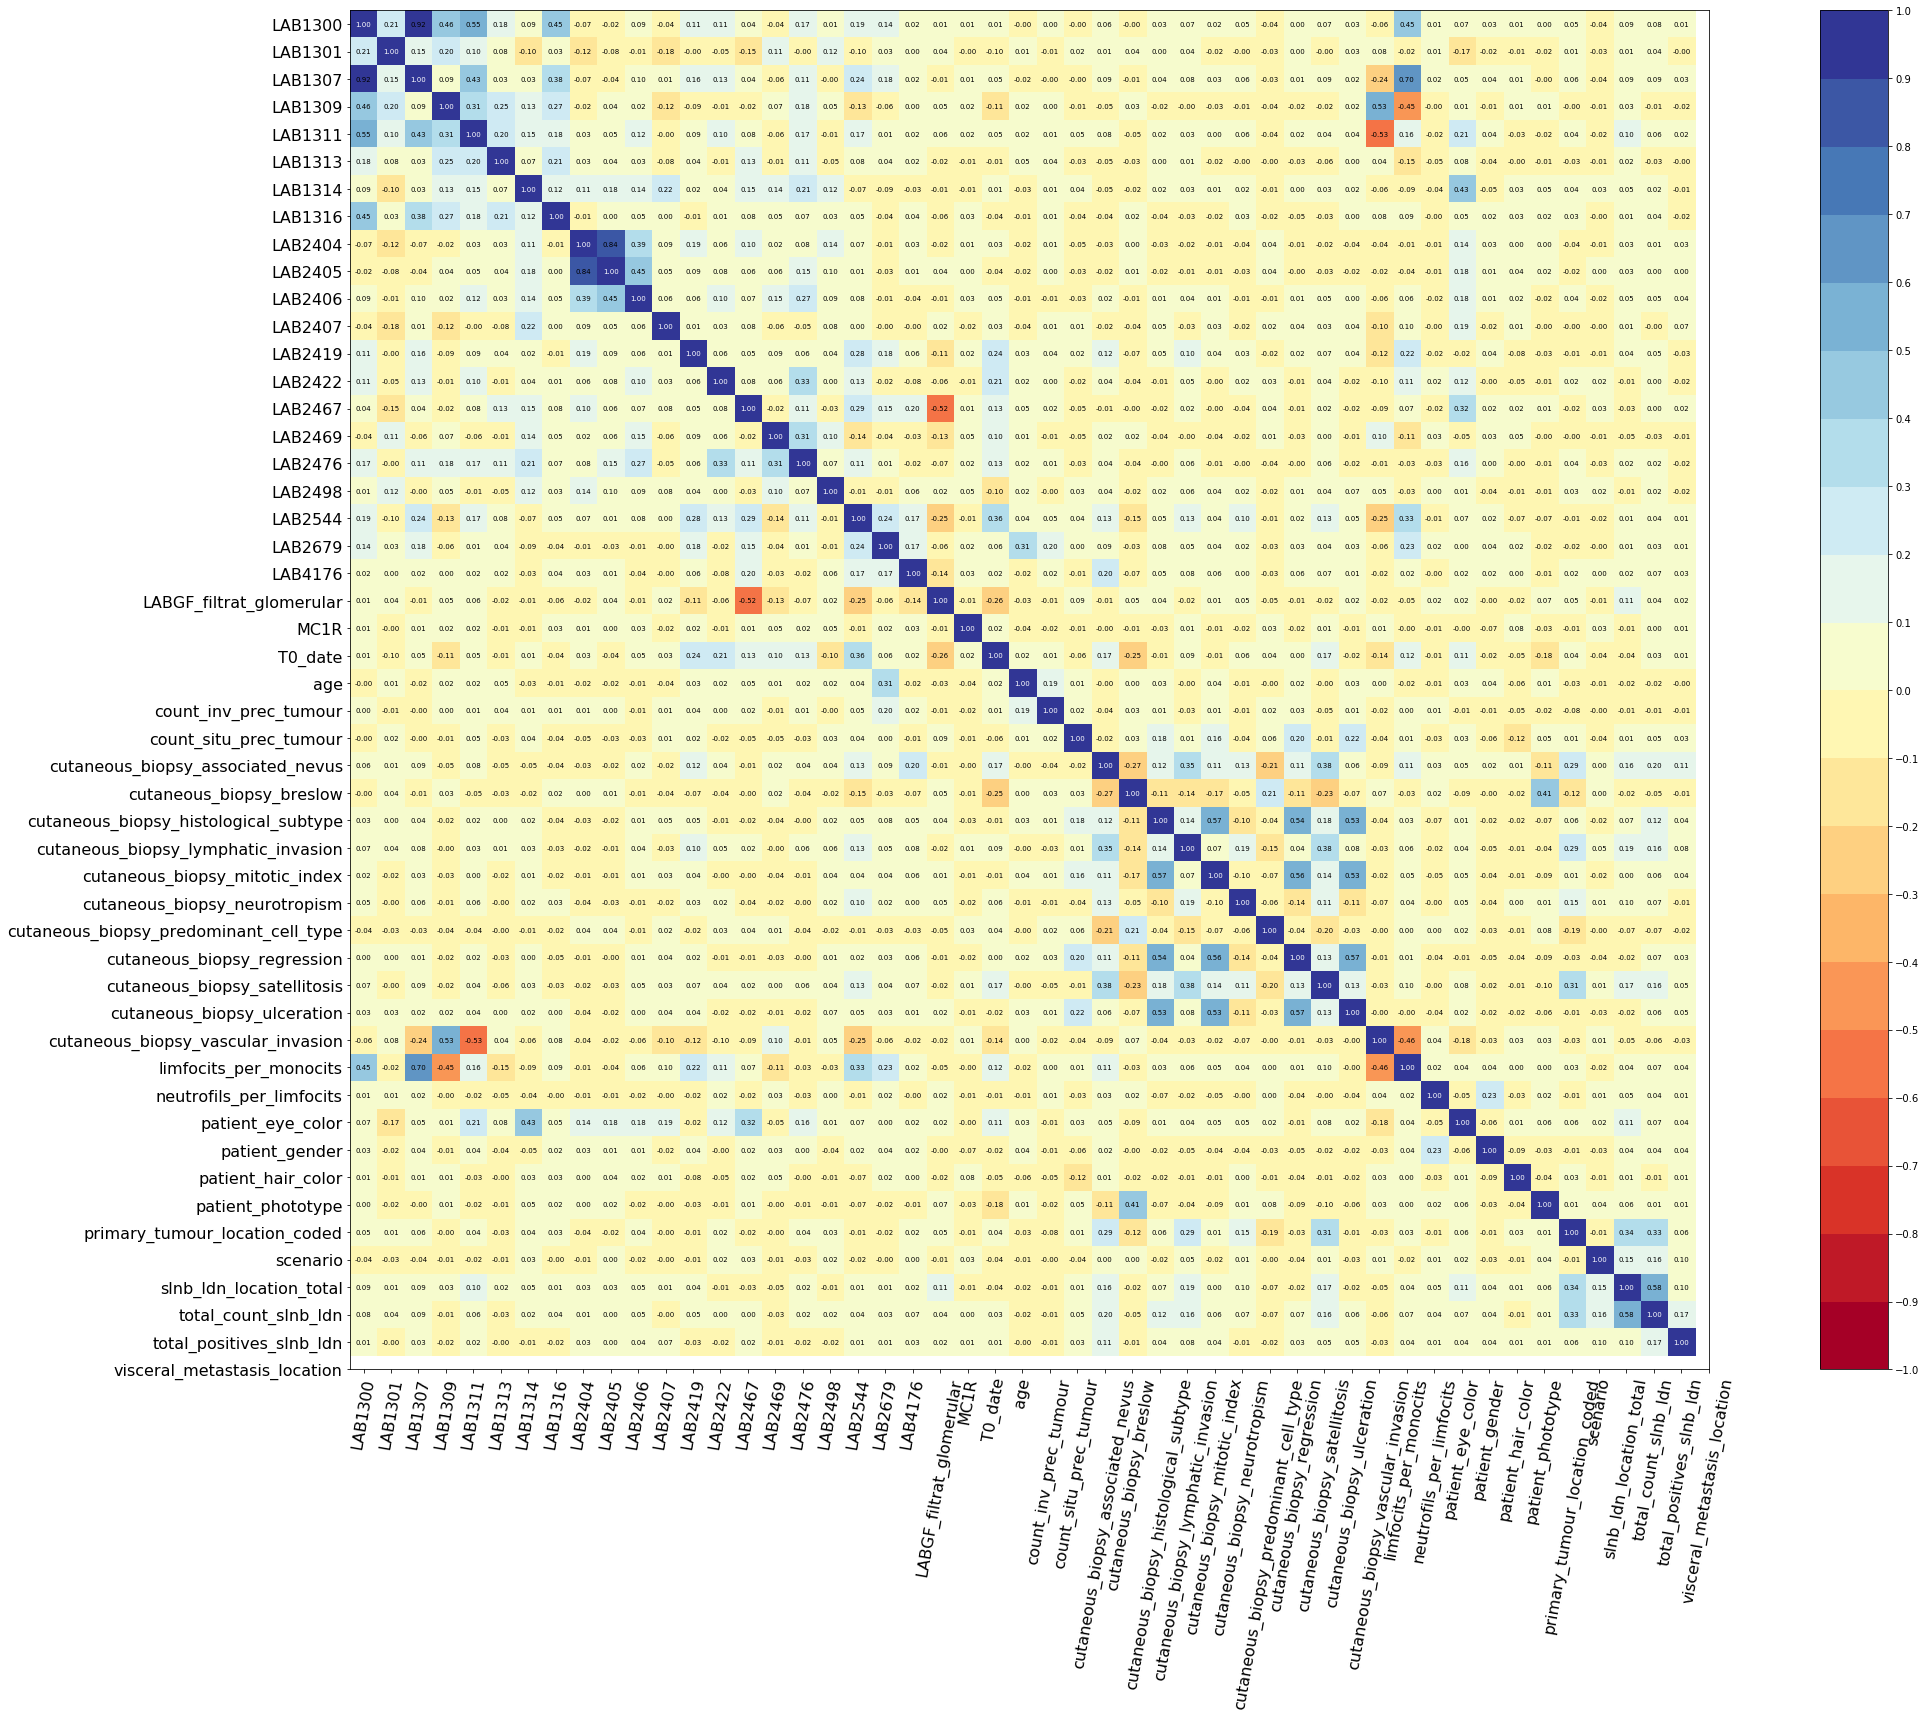

In [13]:
from pysurvival.utils.display import correlation_matrix
correlation_matrix(dataset[features], figure_size=(40,25), text_fontsize=7)

In [14]:
# Building training and testing sets
from sklearn.model_selection import train_test_split
# dataset = pd.read_csv("datasets/train.csv",  index_col='ID')
train, test = train_test_split(dataset, test_size = 0.20)

In [15]:
x_train = train[clmn_list]
t_train = train['months_survival']
e_train = train['specific_death']

In [16]:
structure = [
    {
        'activation': 'Sigmoid',
        'num_units': 128
    },
    {
        'activation': 'ReLU',
        'num_units': 128
    }
]

In [17]:
nonlinear_coxph = NonLinearCoxPHModel(structure=structure)
nonlinear_coxph.fit(x_train, t_train, e_train, lr=1e-3, num_epochs=10,init_method='xav_uniform')

NonLinearCoxPHModel( Layer(1): activation = Sigmoid, num_units = 128 ; 
                     Layer(2): activation = ReLU, num_units = 128 )

In [18]:
x_test = test[clmn_list]
t_test = test['months_survival']
e_test = test['specific_death']

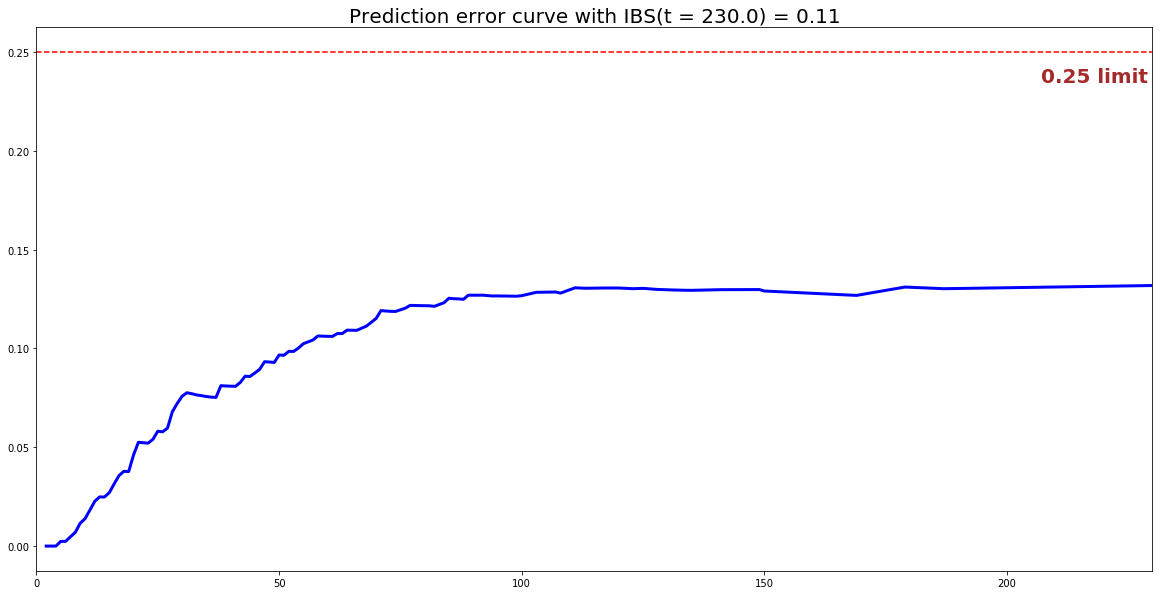

0.10984211827142112

In [19]:
#### 5 - Cross Validation / Model Performances
# c_index = concordance_index(nonlinear_coxph, X_test, T_test, E_test) #0.81
# print('C-index: {:.2f}'.format(c_index))

integrated_brier_score(nonlinear_coxph, x_test, t_test, e_test, t_max=None, figure_size=(20, 10))

